# Creating a Mock Triple Population 
#### written by Cheyanne Shariat 
#### *Shariat, El-Badry, & Naoz (2025)*

In [91]:
# ------------------------------------------------------------------------------------------------------
# Uncomment below if would like to create a the binary population from scratch (need COSMIC installed)
# Otherwise can just read it in (from the repo)
# ------------------------------------------------------------------------------------------------------

# from cosmic.sample.sampler import multidim
# import scienceplots
# from cosmic.sample.initialbinarytable import InitialBinaryTable
# from cosmic.evolve import Evolve
# from cosmic.plotting import a_from_p
# from cosmic.sample.sampler import multidim # !NOTE: assumes corrected multidim.py file in COSMIC (see footnote 2 of paper)
# InitialBinaries, mass_singles, mass_binaries, n_singles, n_binaries,singles_imf = InitialBinaryTable.sampler('multidim', final_kstar1=np.linspace(0,14,15), final_kstar2=np.linspace(0,14,15), rand_seed=11, nproc=1, SF_start=13700.0, SF_duration=0.0, met=0.02, size=1000000)


In [1]:
# Import Helper Functions
from triples_sampling_utils import *

# Imports

In [2]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random as random
from scipy.interpolate import interp1d
import scienceplots
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import newton

random.seed(1)  # set random seed for consistent sampling
pd.set_option('display.max_columns', None)

# os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]
data_PATH = "./Data/"

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use(["science","notebook"]) 
plt.rc('font', family='serif')

plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)  # Set x-axis tick label size
plt.rc('ytick', labelsize=20)  # Set y-axis tick label size


## Read in Observed Triples

In [19]:
# entire triple catalog
triples_catalog = pd.read_csv(data_PATH + "triples_catalog.csv") 

# 100 pc MS triples
triples100 = triples_catalog.query("1000/inner_star1_parallax<100 and triple_type in ['MSMS-MS']") # 100 pc MS triples
distances_resolvedtrip = 1000 / triples100['inner_star1_parallax'] # distances to triples

print(f"{len(triples100)} MSMS-MS triples within 100 pc")

423 MSMS-MS triples within 100 pc


## read in stellar population with Kroupa IMF

In [4]:
# Read in ~3e6 singles and 1e6 binaries sampled from Moe and Di Stefano 2017 multi dim sampling
# used COSMIC with modified multidim.py for sampling (see paper for details)

# Read in single stars
m1s_single = np.loadtxt('./Data/singles_imf.txt') # single star masses

# Uncomment '.query("porb>20") ' if sampling an initial population
initial_binaries = pd.read_csv("./Data/mutlidim_binaries_initial.csv") #.query("porb>20") 


## From binaries, create triples

### initial (`_i`)

In [5]:
# Takes ~10 seconds, for shorter runtime load in fewer initial_binaries
m1s_binaries_i = initial_binaries['mass_1'].values
print(f"N binaries initial = {len(initial_binaries)}")

# Assign triple fraction to binaries, depends on their primary mass 
triple_probs = np.vectorize(get_triple_fraction)(m1s_binaries_i)
triple_mask = np.random.rand(len(m1s_binaries_i)) < triple_probs

# Extract triples
inner_binaries_triples_i = initial_binaries[triple_mask]

# Assign tertiary mass based on power law
inner_binaries_triples_i.loc[:,'q_out'] = sample_power_law(alpha=-1.4, xmin=0.1, xmax=5, size=len(inner_binaries_triples_i))
inner_binaries_triples_i.loc[:,'mass_3'] = (inner_binaries_triples_i['q_out'] * (inner_binaries_triples_i['mass_1'] + inner_binaries_triples_i['mass_2'])).values

print(f"N triples initial = {len(inner_binaries_triples_i)}")


N binaries initial = 1000000
N triples initial = 224468


/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_3334/4086065261.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_binaries_triples_i.loc[:,'q_out'] = sample_power_law(alpha=-1.4, xmin=0.1, xmax=5, size=len(inner_binaries_triples_i))
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_3334/4086065261.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_binaries_triples_i.loc[:,'mass_3'] = (inner_binaries_triples_i['q_out'] * (inner_binaries_triples_i['mass_1'] + inner_binarie

### triples after 10 Gyr of stellar evolution (`_on_ms`) 

In [6]:
# import mass-MS lifetime from MIST isochones
mass_age_MS = pd.read_csv("./Data/MS_mass_age.csv")
masses, MS_lifetime = mass_age_MS['Mass'].values, mass_age_MS['Age'].values

# Interpolate mass-ms_lifetime to see which triples are still on the main sequence
mass_age_interp = interp1d(masses, MS_lifetime, kind='linear', fill_value="extrapolate")

# MS lifetime of each binary
initial_binaries.loc[:, 'ms_lifetime1'] = mass_age_interp(initial_binaries['mass_1'].values)
initial_binaries.loc[:, 'ms_lifetime2'] = mass_age_interp(initial_binaries['mass_2'].values)

# MS lifetime of each triples
inner_binaries_triples_i.loc[:, 'ms_lifetime1'] = mass_age_interp(inner_binaries_triples_i['mass_1'].values)
inner_binaries_triples_i.loc[:, 'ms_lifetime2'] = mass_age_interp(inner_binaries_triples_i['mass_2'].values)
inner_binaries_triples_i.loc[:, 'ms_lifetime3'] = mass_age_interp(inner_binaries_triples_i['mass_3'].values)

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_3334/44153589.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_binaries_triples_i.loc[:, 'ms_lifetime1'] = mass_age_interp(inner_binaries_triples_i['mass_1'].values)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_3334/44153589.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_binaries_triples_i.loc[:, 'ms_lifetime2'] = mass_age_interp(inner_binaries_triples_i['mass_2'].values)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw400

### how many triples still on MS?

In [7]:
# Give each system an age (assuming constant a star formation rate)
# Then determine whether the system is still on the MS today

# Singles
ms_lifetimes_singles = mass_age_interp(m1s_single) 
random_ages = np.random.uniform(0, 10e9, size=len(m1s_single)) # assign ages
still_on_ms_mask = random_ages < ms_lifetimes_singles # which ones still on main sequence?
m1s_singles_on_ms = m1s_single[still_on_ms_mask] # store those still on the main-sequence today

# Binaries
initial_binaries['age'] = np.random.uniform(0, 10e9, size=len(initial_binaries)) # assign ages
on_ms_mask = "(age < ms_lifetime1) and (age < ms_lifetime2)" # which ones still on main sequence?
initial_binaries_on_ms = initial_binaries.query(on_ms_mask) # store those still on the main-sequence today

# Triples
inner_binaries_triples_i['age'] = np.random.uniform(0, 10e9, size=len(inner_binaries_triples_i)) # assign ages
on_ms_mask = "(age < ms_lifetime1) and (age < ms_lifetime2) and (age < ms_lifetime3)" # which ones still on main sequence?
inner_binaries_triples_on_ms = inner_binaries_triples_i.query(on_ms_mask) # store those still on the main-sequence today


print(f"N Singles  = {len(m1s_singles_on_ms)}")
print(f"N Binaries = {len(initial_binaries_on_ms)}")
print(f"N Triples  = {len(inner_binaries_triples_on_ms)}")

N Singles  = 2972695
N Binaries = 837541
N Triples  = 136507


/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_3334/1901578874.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner_binaries_triples_i['age'] = np.random.uniform(0, 10e9, size=len(inner_binaries_triples_i)) # assign ages


In [8]:
# Convert to NumPy views: faster for sampling triples later
INNER_ARRS  = {
    "initial": {k: inner_binaries_triples_i[k].to_numpy()      for k in ("mass_1", "mass_2", "mass_3", "porb", "ecc")},
    "final"  : {k: inner_binaries_triples_on_ms[k].to_numpy()  for k in ("mass_1", "mass_2", "mass_3", "porb", "ecc")},
}
LENGTHS     = {k: len(v["mass_1"]) for k,v in INNER_ARRS.items()}

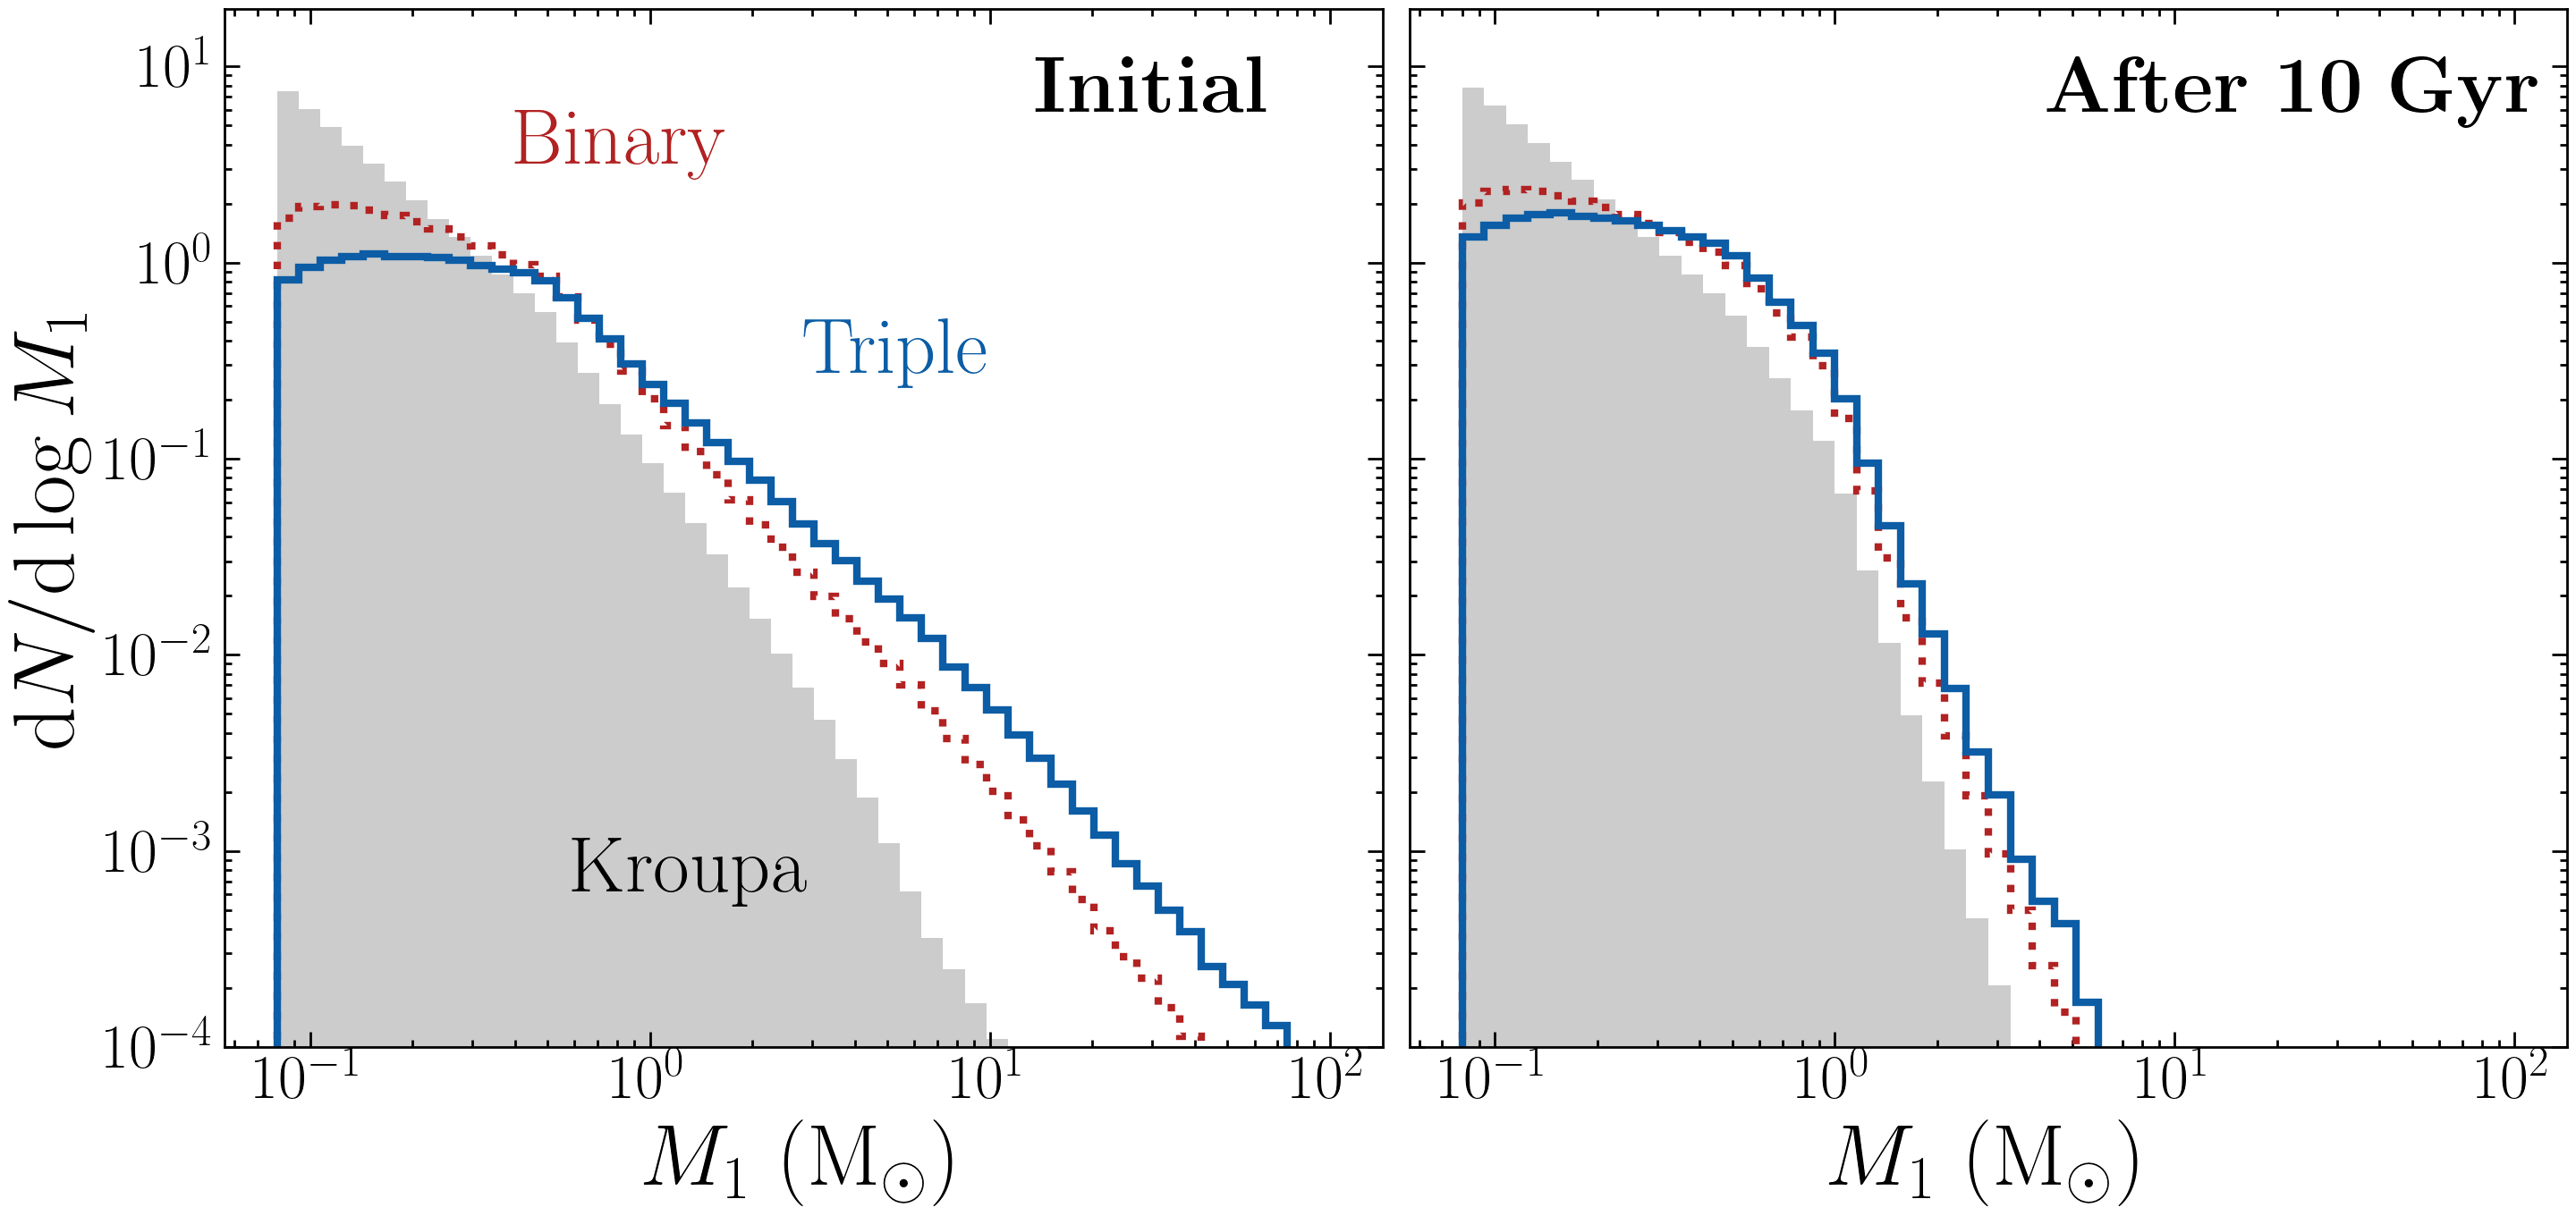

In [17]:
def plot_mass_dist_before_after():
    fig, axes = plt.subplots(1, 2, figsize=(15, 7),sharey=True,sharex=True)

    # First plot: Initial Primary Masses
    bins = np.logspace(np.log10(0.08), np.log10(100.), 50)

    # Histograms
    axes[0].hist(m1s_single, bins=bins, density=True, histtype='stepfilled', color='k', linewidth=3, label='', alpha=0.2)
    axes[0].hist(initial_binaries['mass_1'], bins=bins, density=True, histtype='step', color='firebrick', linewidth=3, label='Binary', linestyle=':')
    axes[0].hist(inner_binaries_triples_i['mass_1'], bins=bins, density=True, histtype='step', color='C0', linewidth=3, label='Triple')

    # Formatting
    axes[0].set_xlabel(r"$M_1~{\rm (M_\odot)}$", fontsize=35)
    axes[0].set_ylabel(r"${\rm d}N/{\rm d}\log M_1$", fontsize=35)
    axes[0].text(0.3, 0.15, "Kroupa", transform=axes[0].transAxes, fontsize=32, color='k')
    axes[0].text(0.25, 0.85, "Binary", transform=axes[0].transAxes, fontsize=32, color='firebrick')
    axes[0].text(0.5, 0.65, "Triple", transform=axes[0].transAxes, fontsize=32, color='C0')
    axes[0].text(0.7, 0.9, r"${\bf Initial}$", transform=axes[0].transAxes, fontsize=32, color='k')
    axes[0].tick_params(axis='both', labelsize=25)
    axes[0].loglog()
    axes[0].set_ylim(bottom=1e-4)

    # Second plot: Final Primary Masses
    bins = np.logspace(np.log10(0.08), np.log10(100.), 49)

    # Histograms
    axes[1].hist(m1s_singles_on_ms, bins=bins, density=True, histtype='stepfilled', color='k', linewidth=3, label='', alpha=0.2)
    axes[1].hist(initial_binaries_on_ms['mass_1'], bins=bins, density=True, histtype='step', color='firebrick', linewidth=3, label='Binary', linestyle=':')
    axes[1].hist(inner_binaries_triples_on_ms['mass_1'], bins=bins, density=True, histtype='step', color='C0', linewidth=3, label='Triple')

    # Formatting
    axes[1].set_xlabel(r"$M_1~{\rm (M_\odot)}$", fontsize=35)
    axes[1].text(0.55, 0.9, r"${\bf After~10~Gyr}$", transform=axes[1].transAxes, fontsize=32, color='k')
    axes[1].tick_params(axis='both', labelsize=25)

    plt.tight_layout()
    plt.show()

plot_mass_dist_before_after()

# Main Function: Mock Triples Population

In [10]:
def sample_triples(Periods : str = 'DM91', 
                   e_out : str = 'thermal',
                   initial_or_final : str = 'final',
                       ): 
    """Sample triple parameters

    Args:
        Periods (str)          : Period Distribution. 
        e_out (str)            : e_out distribution (eccentricity of outer orbit). 
                                    'thermal' = thermal e_out distribution, 
                                    'uniform' = unfirom e_out distribution, U(0,1)
        initial_or_final (str) : Initial or Final Triple Population. 
                                    'initial' = All Triples at t=0, period > 20 days. 
                                    'final' = Only those on MS today, includes period<20 days

    Returns:
        Triple Parameters: masses (m1, m2, m3), semi-major axes (a1, a2), eccentricities (e1, e2), mutual inclination (i)
         np.array: m1,m2,m3,R1,R2,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,t_i,age
    """
    
    # Sample a triple inner binary
    idx = np.random.randint(LENGTHS[initial_or_final])

    # 2. fast field access (no .loc, no .values[0], no copy)
    arrs = INNER_ARRS[initial_or_final]
    m1, m2, m3   = arrs["mass_1"][idx], arrs["mass_2"][idx], arrs["mass_3"][idx]
    P_in, e1     = arrs["porb"][idx] / 365.25, arrs["ecc"][idx]
    q_out = m3 / (m1+m2)

    
    R1 = 1.01 * m1**(0.8) # M-R relation 
    R2 = 1.01 * m2**(0.8) # M-R relation 
        
    age = np.random.uniform(0,12e3) #5e3 #*1.e6, 


    # log normal following DM+1991, Winters+2019 log-normal for M-dwarfs
    if Periods == 'combined_log_normal_DM91':
        if m1 < 0.6:
            mu,sigma = np.log10(20), 1.16 # if low mass primary, use Fischer (more close binaries)
            a2 = 10**np.random.normal(mu,sigma)  #periods in days #10**np.random.normal(4.8,2.3)
            P_out = Kepler_3rdLaw_SMA(m1+m2,m3,a2)

        else:
            mu,sigma = 4.8, 2.3 
            P_out = 10**np.random.normal(mu,sigma) / 365.25 #periods in days #10**np.random.normal(4.8,2.3)
    
    # log normal following Raghavan+2010, Winters+2019 log-normal for M-dwarfs
    if Periods == 'combined_log_normal_R10':
        if m1 < 0.6:
            mu,sigma = np.log10(20), 1.16 # if low mass primary, use Fischer (more close binaries)
            a2 = 10**np.random.normal(mu,sigma)  #periods in days #10**np.random.normal(4.8,2.3)
            P_out = Kepler_3rdLaw_SMA(m1+m2,m3,a2)
        else:
            mu,sigma = 5.03, 2.28 
            P_out = 10**np.random.normal(mu,sigma) / 365.25 #periods in days #10**np.random.normal(4.8,2.3)
    
    # log-uniform distribution
    if Periods == 'log_uniform':
        a2 = sample_log_uniform(x1 = 10, x2=300000, size=1)[0]
        P_out = Kepler_3rdLaw_SMA(m1+m2,m3,a2)
        

    a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) 

    e2 = get_outer_eccentricity(e_out = e_out)
    
    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    
    # check if stable
    criteria = get_all_criteria(a1,a2,e1,e2,m1=m1,m2=m2,m3=m3,R1=R1,R2=R2,i=i,q_out=q_out,simple=False)
    hierarchical_formation = True
    if hierarchical_formation:
        n=0
        while not criteria and n <= 50:
            n+=1
            if Periods == 'DM91': # can change this for other periods
                mu,sigma = 4.8, 2.3
                P_out = 10**np.random.normal(mu,sigma) / 365.25
                a2 = Kepler_3rdLaw(P_out,m1+m2,m3)
                e2  = sample_thermal_eccentricity(n_samples = 1)[0]
            elif Periods == 'Raghavan+10':
                mu,sigma = 5.0, 2.3
                P_out = 10**np.random.normal(mu,sigma) / 365.25
                a2 = Kepler_3rdLaw(P_out,m1+m2,m3)
                e2  = sample_thermal_eccentricity(n_samples = 1)[0]
            elif Periods == 'LU':
                a2 = sample_log_uniform(x1 = 10, x2=100000, size=1)[0]
                e2  = sample_thermal_eccentricity(n_samples = 1)[0]

            criteria = get_all_criteria(a1,a2,e1,e2,m1=m1,m2=m2,m3=m3,R1=R1,R2=R2,i=i,q_out=q_out,simple=False) # get criteria with tertiary parameters

    if criteria:
        return np.array([m1,m2,m3,a1,a2,e1,e2,i,age])
    else:
        return sample_triples(Periods = Periods, initial_or_final = initial_or_final) # recurse until find stability
        


# Example Sampling 

### Generates a triple population, indicates which would be resolved by Gaia

In [11]:
def sample_all(N, Periods='DM91', e_out = 'thermal', initial_or_final='final'):
    # wrapper function to call sample_triples function, add projected separations, and apply the Gaia Selection Function (which are resolved)
    
    # Preallocate arrays 
    m1s = np.empty(N)
    m2s = np.empty(N)
    m3s = np.empty(N)
    a1s = np.empty(N)
    a2s = np.empty(N)
    e1s = np.empty(N)
    e2s = np.empty(N)

    
    for i in range(N):
        m1, m2, m3, a1, a2, e1, e2, inc, age = sample_triples(
            Periods=Periods, 
            e_out = e_out,
            initial_or_final = initial_or_final
        )
        m1s[i] = m1
        m2s[i] = m2
        m3s[i] = m3
        a1s[i] = a1
        a2s[i] = a2
        e1s[i] = e1
        e2s[i] = e2

    # Compute projected separations (assumed vectorized internally)
    s1s, s2s = compute_projected_separations(a1=a1s, a2=a2s, e1=e1s, e2=e2s, num_samples=1)

    # Construct DataFrame
    results_df = pd.DataFrame({
        'ID': np.arange(N),
        'm1': m1s,
        'm2': m2s,
        'm3': m3s,
        'a1': a1s,
        'a2': a2s,
        'e1': e1s,
        'e2': e2s,
        'age': age,
        'I_mut' : inc,
        'sep1_AU': s1s, # projected separations
        'sep2_AU': s2s  # projected separations
    })

    # If add_resolved_new is slow, check if it's vectorized
    results_df = add_resolved_new(results_df, gaia_distances=distances_resolvedtrip, num_iterations=1)

    return results_df

# ---------------
# Example Usage (runtime ~2 seconds for N=10,000, scales linearly)
# ---------------

# DM91 log-uniform periods
results_df_dm91   = sample_all(N = 10000, 
                             Periods = 'combined_log_normal_DM91', 
                             e_out = 'thermal',
                             initial_or_final = 'final')
# results_df_ragh10 = sample_all(N = 10000, 
#                              Periods = 'combined_log_normal_R10', 
#                              e_out = 'thermal',
#                              initial_or_final = 'final')
# results_df_LU     = sample_all(N = 10000, 
#                              Periods = 'log_uniform', 
#                              e_out = 'thermal',
#                              initial_or_final = 'final')


# Can also save files
# results_df_dm91.to_parquet(data_PATH + "results_df_dm91.parquet")

#### what fraction of triples are completely resolved?
#### (Figure 9 of paper)

In [15]:
resolved_frac = len(results_df_dm91.query("resolved_sep == 'Y' and m1>0.1 and m2>0.1 and m3>0.1"))/len(results_df_dm91.query("m1>0.1 and m2>0.1 and m3>0.1"))
print(f"Resolved Fraction: {resolved_frac:.2f}")

Resolved Fraction: 0.03


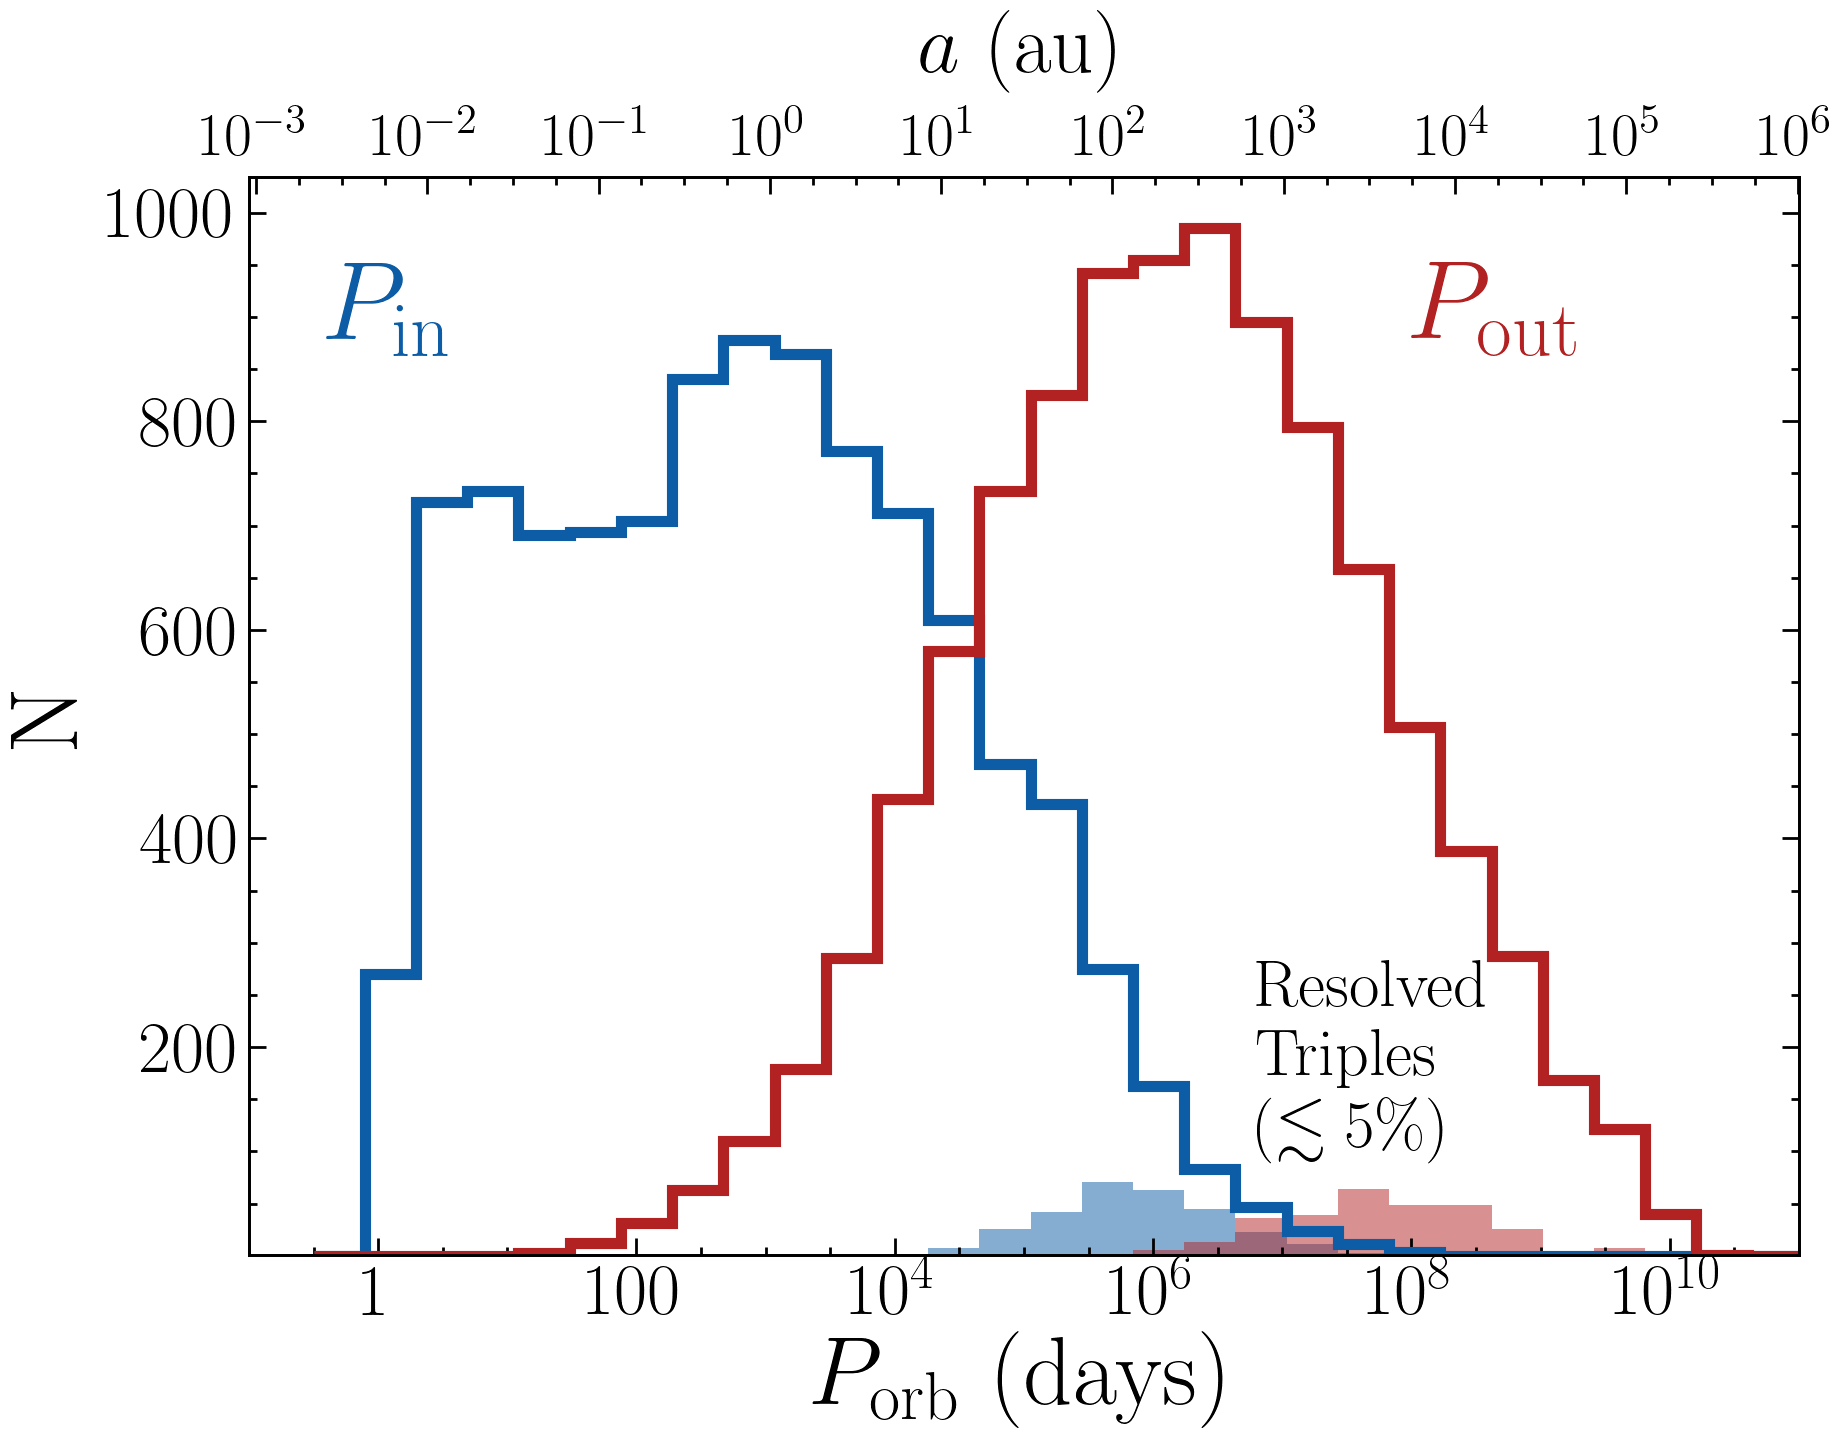

In [16]:
def plot_periods_resolved(P1,P2, P1_resolved,P2_resolved):
    fig, ax = plt.subplots(figsize=(10, 7))

    bins = np.linspace(-0.5, 11, 30)

    ax.hist(np.log10(P1*365.25), bins=bins,histtype='step',density=False, color='C0', linewidth=4, label='', rasterized=True)
    ax.hist(np.log10(P2*365.25), bins=bins,histtype='step',density=False, color='firebrick', linewidth=4, label='', rasterized=True)
    ax.hist(np.log10(P1_resolved*365.25), bins=bins, histtype='stepfilled', density=False, color='C0', linewidth=1, label='', alpha=0.5,edgecolor=None, rasterized=True)
    ax.hist(np.log10(P2_resolved*365.25), bins=bins, histtype='stepfilled', density=False, color='firebrick', linewidth=1, label='', alpha=0.5,edgecolor=None, rasterized=True)

    ax.text(0.65, 0.1, "Resolved\nTriples\n" + r"($\lesssim 5\%$)", fontsize=24, color='black', rotation=0,transform = ax.transAxes)

    ax.set_xlabel(r"$P_{\rm orb}$ (days)", fontsize=35, labelpad=1)
    ax.set_ylabel(r"N", fontsize=35)

    ax.text(0.05, 0.85, r"$P_{\rm in}$", transform=ax.transAxes, fontsize=40,color='C0')
    ax.text(0.75, 0.85, r"$P_{\rm out}$", transform=ax.transAxes, fontsize=40,color='firebrick')

    log_P_ticks = [-2,0,2,4,6,8,10]
    ax.set_xticks(log_P_ticks, ['0.01','1','100'] + [f"$10^{{{int(P)}}}$" for P in log_P_ticks[3:]])  # Pretty labels


    log_a_ticks = np.arange(-3., 7.) 
    logP_ticks = np.log10(Kepler_3rdLaw_SMA(1, 0, 10**log_a_ticks)*365.25)

    # Add top axis
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())

    ax_top.set_xticks(logP_ticks, [f"$10^{{{int(a)}}}$" for a in log_a_ticks])
    ax_top.set_xlabel(r"$a$ (au)", fontsize=30, labelpad=15)
    ax_top.tick_params(axis='both', labelsize=22)
    ax.tick_params(axis='both', labelsize=26)

    ax.set_xlim(left=-1,right=11)
    ax.set_ylim(bottom=0.8)

    # plt.savefig("/Users/bijan1339/Desktop/Research/Figures/triple_resolved_N.pdf")
    plt.show()
    
P1, P2 = Kepler_3rdLaw_SMA(results_df_dm91.m1, results_df_dm91.m2, results_df_dm91.a1), Kepler_3rdLaw_SMA(results_df_dm91.m1+results_df_dm91.m2, results_df_dm91.m3, results_df_dm91.a2)

# Inner Orbit
P1_resolved = Kepler_3rdLaw_SMA(results_df_dm91.query("resolved_sep == 'Y'").m1, 
                                             results_df_dm91.query("resolved_sep == 'Y'").m2, 
                                             results_df_dm91.query("resolved_sep == 'Y'").a1)
# Outer Orbit
P2_resolved = Kepler_3rdLaw_SMA(results_df_dm91.query("resolved_sep == 'Y'").m1+results_df_dm91.query("resolved_sep == 'Y'").m2, 
                                results_df_dm91.query("resolved_sep == 'Y'").m3, 
                                results_df_dm91.query("resolved_sep == 'Y'").a2)

plot_periods_resolved(P1,P2, P1_resolved,P2_resolved)

# Example: Masses
### Figure 5 of paper

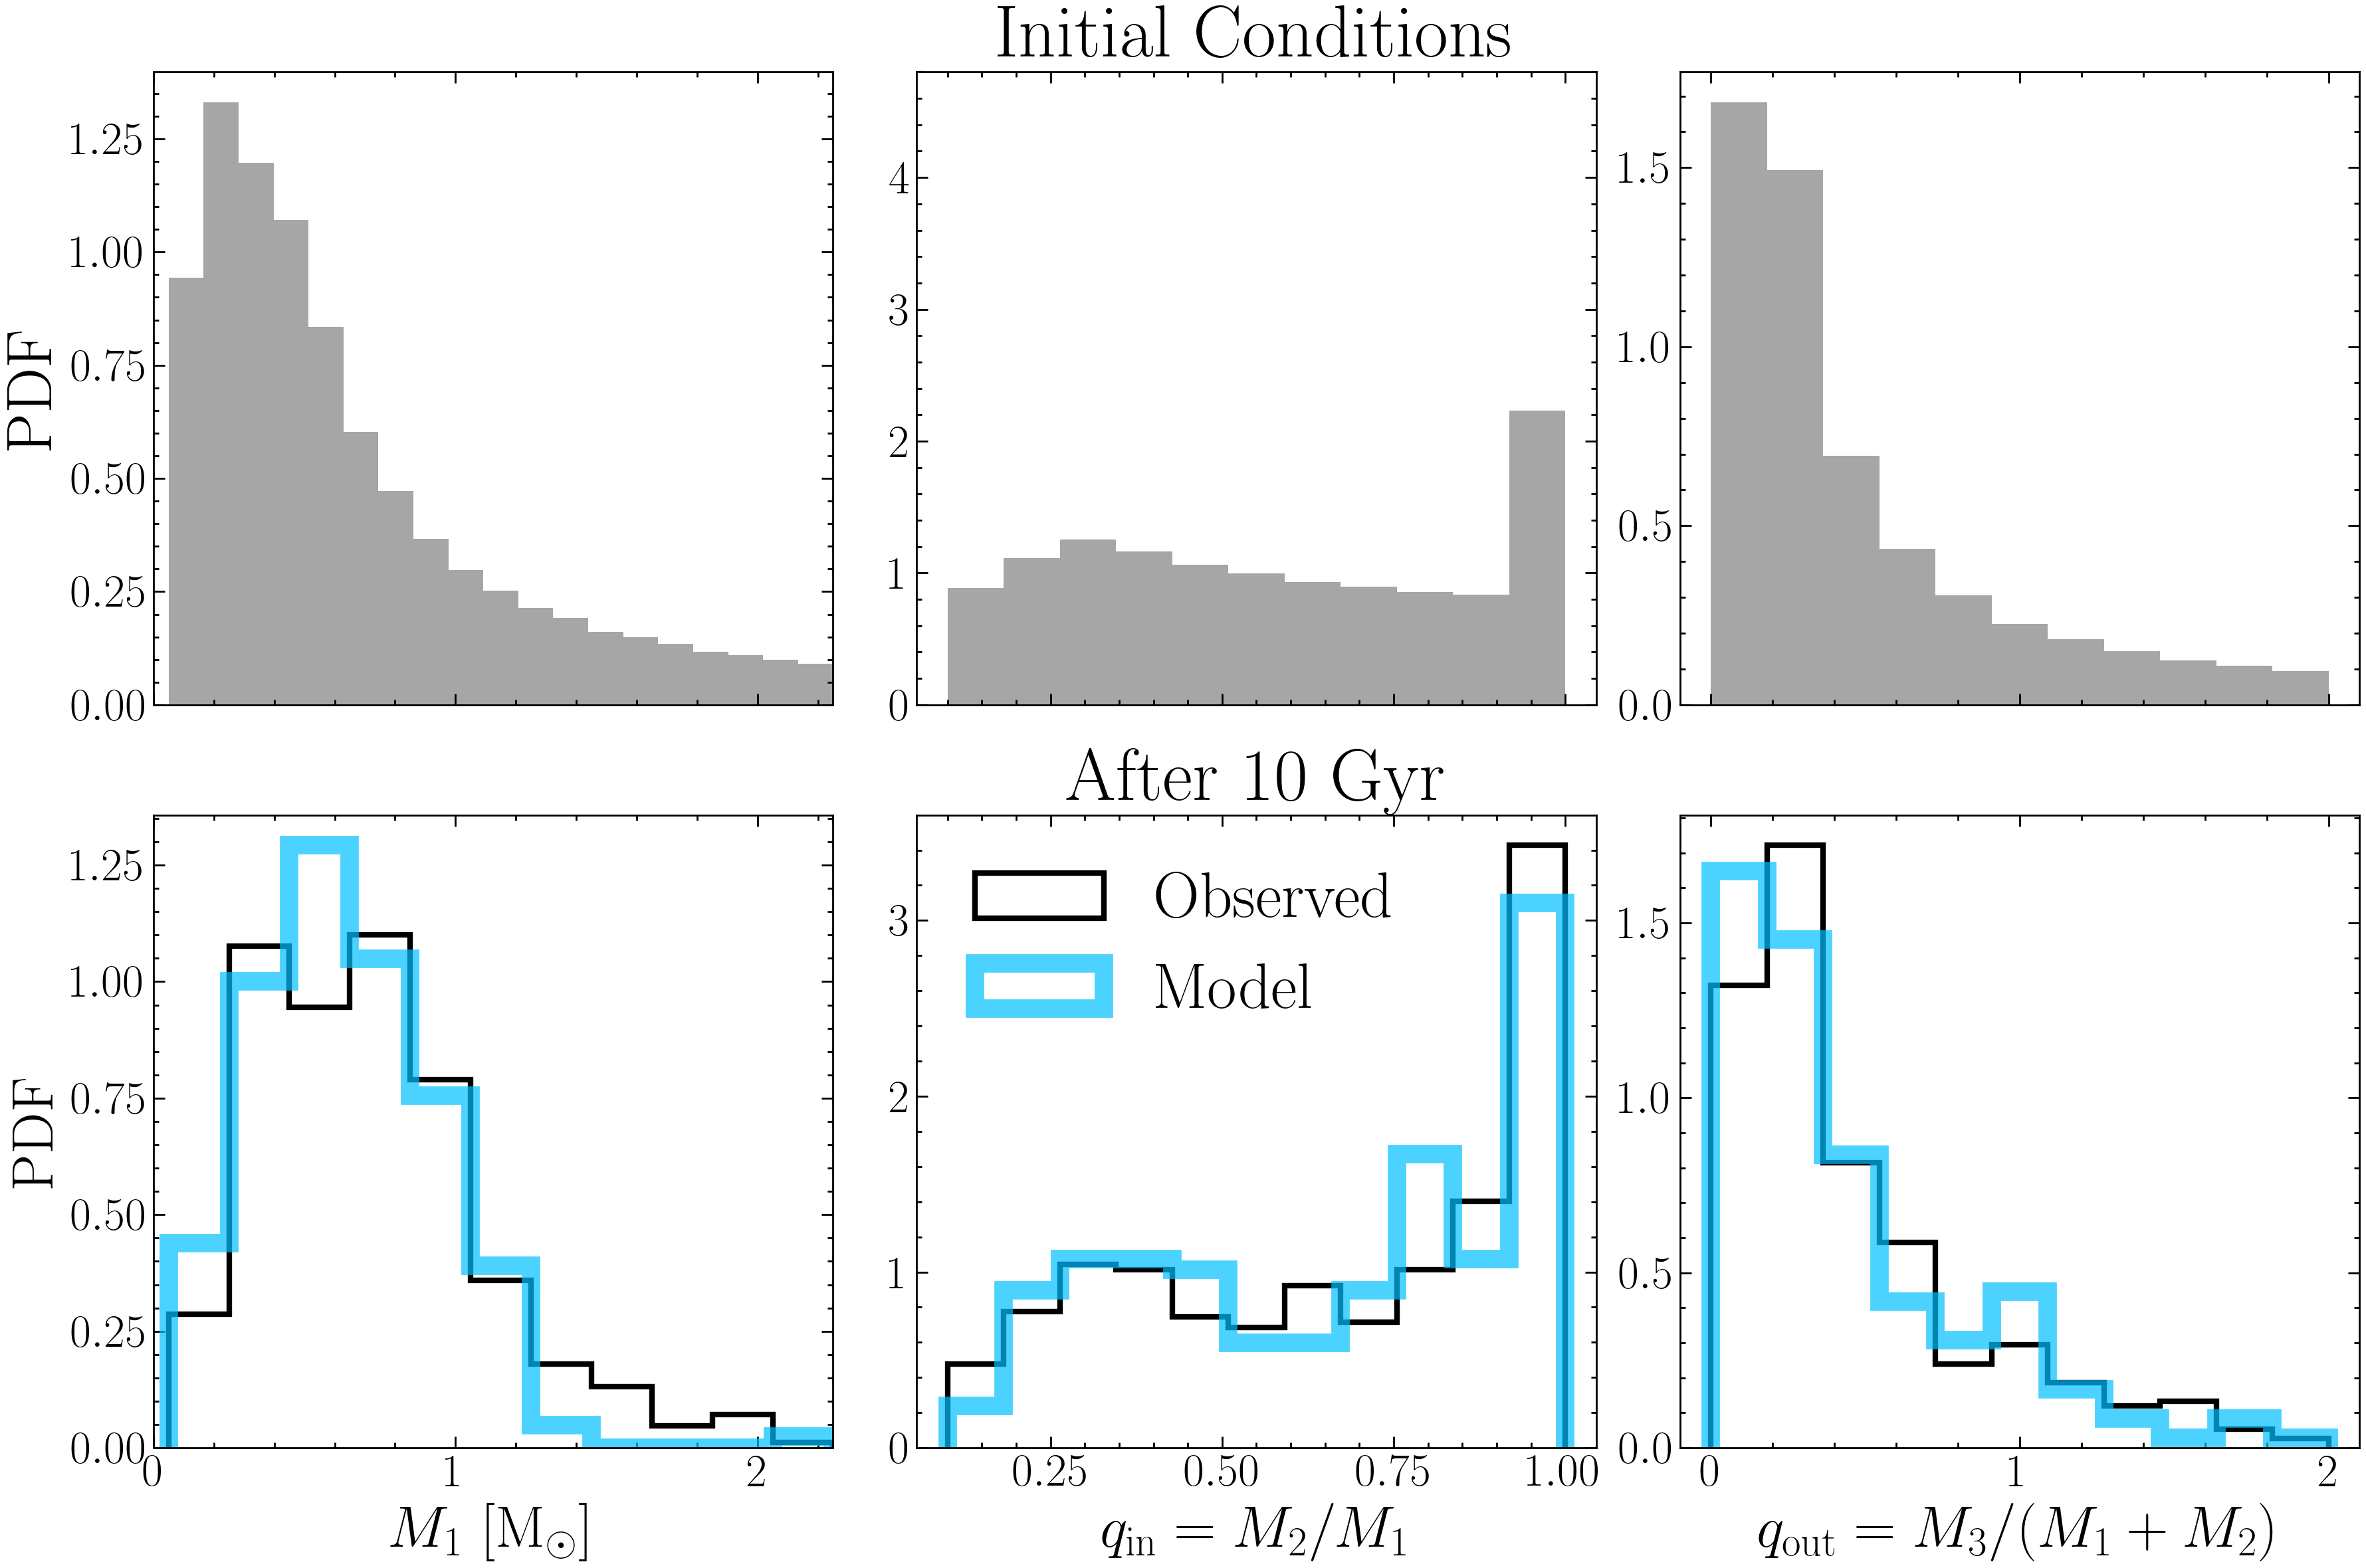

In [15]:
def plot_masses(results_resolved,
                savefig = False, savefig_PATH = "./m_q_compare.pdf"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex='col')

    # Top-left plot: m1 distribution (Initial Conditions)
    bins = np.linspace(0.05, 2.25, 20)
    axes[0, 0].hist(inner_binaries_triples_i['mass_1'], bins=bins, histtype='stepfilled', color='k', linewidth=4, alpha=0.35, density=True)
    axes[0, 0].set_ylabel("PDF", fontsize=35)
    axes[0, 0].set_xlim(left=0,right=2.25)
    axes[0, 1].set_title("Initial Conditions", fontsize=40)

    # Top-middle plot: q_in distribution (Initial Conditions)
    bins = np.linspace(0.1, 1., 12)
    axes[0, 1].hist(inner_binaries_triples_i['mass_2']/inner_binaries_triples_i['mass_1'], bins=bins, histtype='stepfilled', color='k', linewidth=4, alpha=0.35, density=True)
    axes[0, 1].set_ylim(top=4.8)
    
    # Top-right plot: q_out distribution (Initial Conditions)
    bins = np.linspace(0.0, 2., 12)
    axes[0, 2].hist(inner_binaries_triples_i['q_out'], bins=bins, histtype='stepfilled', color='k', linewidth=4, alpha=0.35, density=True)

    # Bottom-left plot: m1 distribution (After 10 Gyr)
    bins = np.linspace(0.05, 2.25, 12)
    axes[1, 0].hist(triples100.mass1, bins=bins, density=True, histtype='step', linewidth=3, label='Observed', color='k')
    axes[1, 0].hist(results_resolved.m1, bins=bins, density=True, histtype='step', linewidth=10, label='Model', color='deepskyblue', alpha=0.7)
    axes[1, 0].set_xlabel(r"$M_1~{\rm [M_\odot]}$", fontsize=32)
    axes[1, 0].set_ylabel("PDF", fontsize=32)

    # Bottom-middle plot: q_in distribution (After 10 Gyr)
    bins = np.linspace(0.1, 1., 12)
    axes[1, 1].hist(triples100.mass2 / triples100.mass1, bins=bins, density=True, histtype='step', linewidth=3, label='Observed', color='k')
    axes[1, 1].hist(results_resolved.m2 / results_resolved.m1, bins=bins, density=True, histtype='step', linewidth=10, label='Model', color='deepskyblue', alpha=0.7)
    axes[1, 1].set_xlabel(r"$q_{\rm in} = M_2/M_1$", fontsize=32)
    axes[1, 1].legend(fontsize=35)
    axes[1, 1].set_title("After 10 Gyr", fontsize=40)

    # Bottom-right plot: q_out distribution (After 10 Gyr)
    bins = np.linspace(0.0, 2., 12)
    axes[1, 2].hist(triples100.mass3 / (triples100.mass1 + triples100.mass2), bins=bins, density=True, histtype='step', linewidth=3, label='Observed', color='k')
    axes[1, 2].hist(results_resolved.m3 / (results_resolved.m1 + results_resolved.m2), bins=bins, density=True, histtype='step', linewidth=10, label='Filtered', color='deepskyblue', alpha=0.7)
    axes[1, 2].set_xlabel(r"$q_{\rm out}= M_3/(M_1+M_2)$", fontsize=32)

    for ax in axes.flat:
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig_PATH)
    plt.show()

results_resolved = results_df_dm91.query("resolved_sep == 'Y' and m1>0.1 and m2>0.1 and m3>0.1")
plot_masses(results_resolved)

# Example: Separations
### Figure 6 of paper

In [17]:
# Cut out some fraction fo the widest systems to approximate reality (see Appendix F of the paper)
import pickle

# Load the interpolation function
with open('prob_survive_sep.pkl', 'rb') as f:
    prob_survive_sep = pickle.load(f)
for df in [results_df_ragh10, results_df_dm91, results_df_LU]:
    df['P_survive'] = prob_survive_sep(np.log10(df['sep2_AU']))
    df['survived'] = np.random.rand(len(df)) < df['P_survive']    # Sample the dataframe based on the survival probability

In [16]:
# Parent Distirbutions
N_samples = len(results_df_dm91)
m1 = np.array([0.5] * N_samples)
m2 = np.array([0.5] * N_samples)
mu,sigma = 5.03, 2.28 
raghavan10_P = 10**np.random.normal(mu,sigma,size=N_samples)
raghavan10_a = Kepler_3rdLaw_Period(raghavan10_P,m1,m2)

mu,sigma = 4.8, 2.3 
DM91_P = 10**np.random.normal(mu,sigma,size=N_samples)
DM91_a = Kepler_3rdLaw_Period(DM91_P,m1,m2)

mu,sigma = 4.1, 1.3 
fisch_P = 10**np.random.normal(mu,sigma,size=N_samples)
fisch_a = Kepler_3rdLaw_Period(fisch_P,m1,m2)

alpha = -1.6
xmin = 50
xmax = 50000
EB18_a = sample_power_law(alpha, xmin, xmax, size=(N_samples, 1))

LU_a = sample_log_uniform(x1 = 1, x2=100000, size=N_samples)


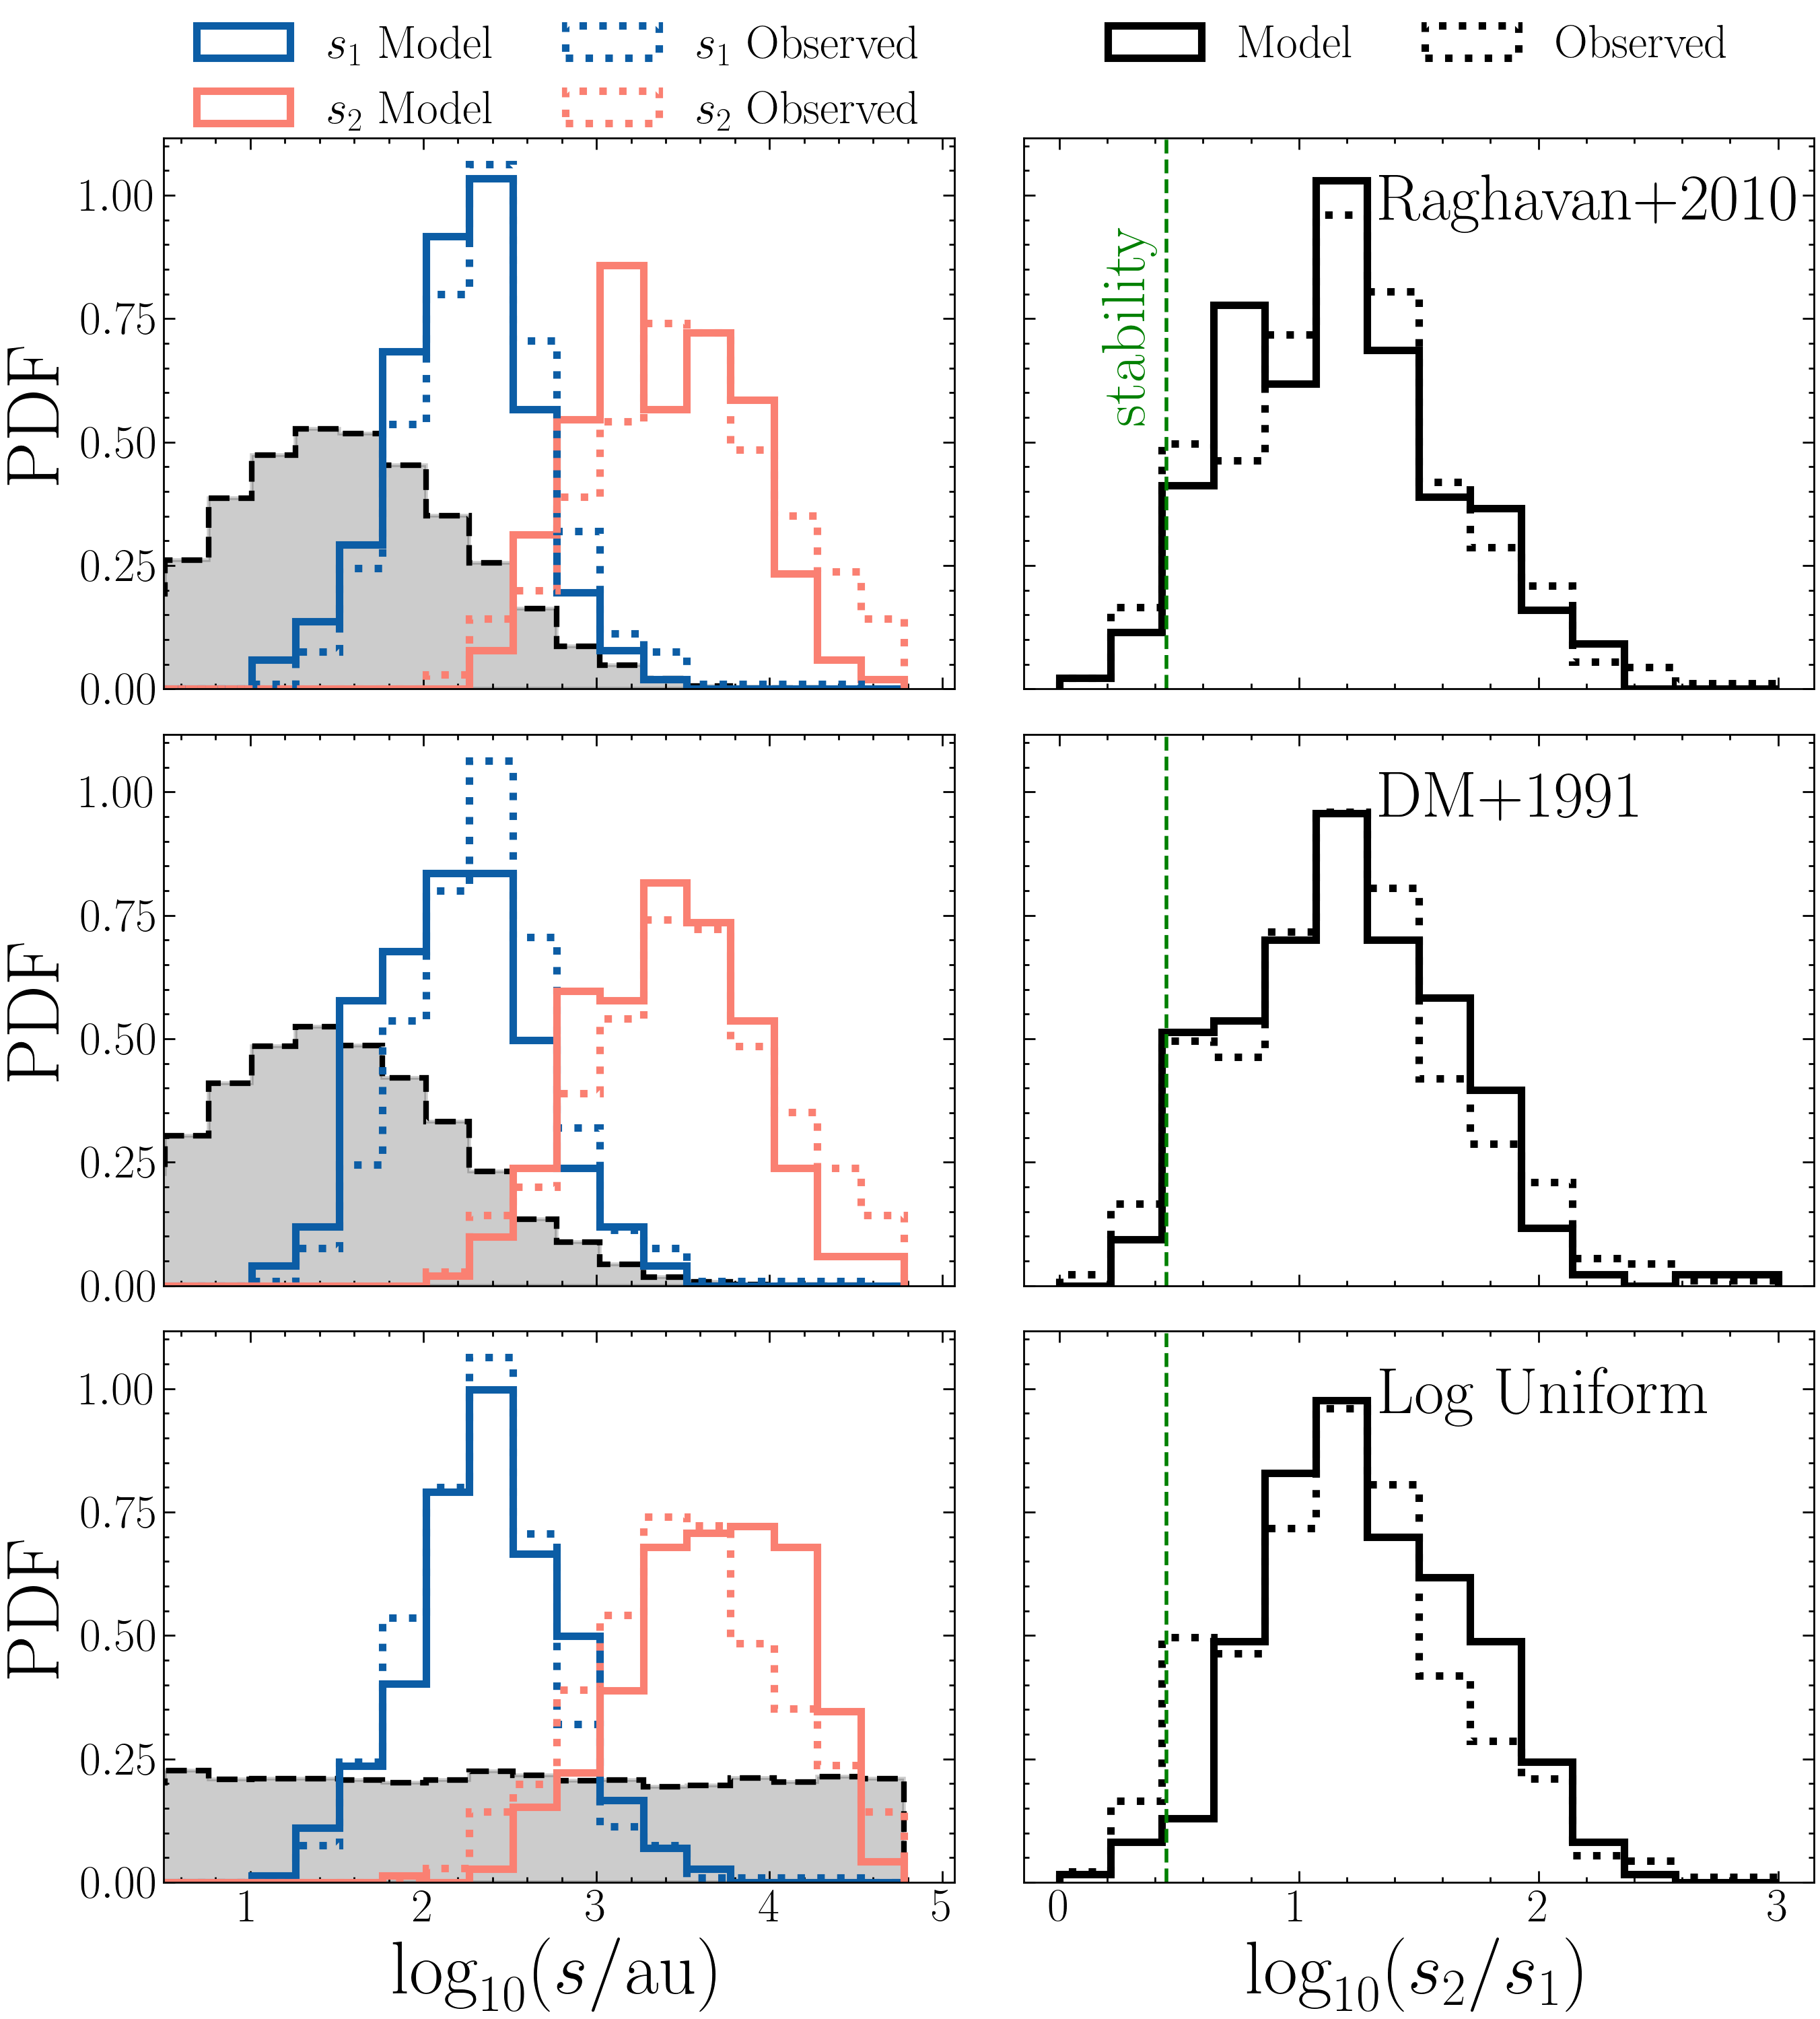

In [ ]:
def plot_sep_dists(savefig = False,
                   savefig_PATH = "./sampled_seps_trip_ALL.pdf"
                   ):
    fig, axes = plt.subplots(3, 2, figsize=(14, 15), sharex='col', sharey=True)
    bins1 = np.linspace(-1, np.log10(60000), 24)
    bins2 = np.linspace(0, 3.0, 15)

    (ax1, ax2), (ax3, ax4), (ax5, ax6) = axes
    raghavan = True
    dm91 = True
    eb18 = True

    # First figure (left column)
    mask1 = mask2 = "resolved_sep == 'Y'  and survived == True and m1>0.1 and m2>0.1 and m3>0.1"

    if raghavan:
        ax1.hist(np.log10(raghavan10_a), bins=bins1, histtype='stepfilled', color='k', edgecolor='k', density=True, linestyle='solid', linewidth=2, alpha=0.2)
        ax1.hist(np.log10(raghavan10_a), bins=bins1, histtype='step', color='k', density=True, linestyle='--', linewidth=3, alpha=1)
        ax1.hist(np.log10(results_df_ragh10.query(mask1).sep1_AU), bins=bins1, histtype='step', density=True, color='C0', linewidth=4, label='$s_1$ Model')
        ax1.hist(np.log10(results_df_ragh10.query(mask1).sep2_AU), bins=bins1, histtype='step', density=True, color='salmon', linewidth=4, label='$s_2$ Model')
        ax1.hist(np.log10(triples100.sep_inner_AU), bins=bins1, histtype='step', density=True, color='C0', linestyle=':', linewidth=4, label='$s_1$ Observed')
        ax1.hist(np.log10(np.mean([triples100.sep_tertiary_to_inner1_AU, triples100.sep_tertiary_to_inner2_AU], axis=0)), bins=bins1, histtype='step', density=True, color='salmon', linestyle=':', linewidth=4, label='$s_2$ Observed')

    if dm91:
        ax3.hist(np.log10(DM91_a), bins=bins1, histtype='stepfilled', color='k', edgecolor='k', density=True, linestyle='solid', linewidth=2, alpha=0.2)
        ax3.hist(np.log10(DM91_a), bins=bins1, histtype='step', color='k', density=True, linestyle='--', linewidth=3, alpha=1)
        ax3.hist(np.log10(results_df_dm91.query(mask1).sep1_AU), bins=bins1, histtype='step', density=True, color='C0', linewidth=4)
        ax3.hist(np.log10(triples100.sep_inner_AU), bins=bins1, histtype='step', density=True, color='C0', linestyle=':', linewidth=4)
        ax3.hist(np.log10(results_df_dm91.query(mask1).sep2_AU), bins=bins1, histtype='step', density=True, color='salmon', linewidth=4)
        ax3.hist(np.log10(np.mean([triples100.sep_tertiary_to_inner1_AU, triples100.sep_tertiary_to_inner2_AU], axis=0)), bins=bins1, histtype='step', density=True, color='salmon', linestyle=':', linewidth=4)

    if eb18:
        ax5.hist(np.log10(LU_a), bins=bins1, histtype='stepfilled', color='k', edgecolor='k', density=True, linestyle='solid', linewidth=2, alpha=0.2)
        ax5.hist(np.log10(LU_a), bins=bins1, histtype='step', color='k', density=True, linestyle='--', linewidth=3, alpha=1)
        ax5.hist(np.log10(results_df_LU.query(mask1).sep1_AU), bins=bins1, histtype='step', density=True, color='C0', linewidth=4)
        ax5.hist(np.log10(triples100.sep_inner_AU), bins=bins1, histtype='step', density=True, color='C0', linestyle=':', linewidth=4)
        ax5.hist(np.log10(results_df_LU.query(mask1).sep2_AU), bins=bins1, histtype='step', density=True, color='salmon', linewidth=4)
        ax5.hist(np.log10(np.mean([triples100.sep_tertiary_to_inner1_AU, triples100.sep_tertiary_to_inner2_AU], axis=0)), bins=bins1, histtype='step', density=True, color='salmon', linestyle=':', linewidth=4)

    # Second figure (right column)
    # mask2 = "resolved_sep == 'Y'  and survived == True and m1>0.1 and m2>0.1 and m3>0.1"
    if raghavan:
        ax2.hist(np.log10(results_df_ragh10.query(mask2).sep2_AU / results_df_ragh10.query(mask2).sep1_AU), bins=bins2, histtype='step', density=True, color='k', linewidth=4, label='Model')
        ax2.hist(np.log10(np.mean([triples100.sep_tertiary_to_inner1_AU, triples100.sep_tertiary_to_inner2_AU], axis=0) / triples100.sep_inner_AU), bins=bins2, histtype='step', density=True, color='k', linestyle=':', linewidth=4, label='Observed')
        ax2.text(0.1, 0.5, "stability", color='green', fontsize=33, rotation=90, transform=ax2.transAxes)
        title = 'Raghavan+2010'
        ax2.text(0.45, 0.85, f'{title}', color='k', transform=ax2.transAxes, fontsize=35)


    if dm91:
        ax4.hist(np.log10(results_df_dm91.query(mask2).sep2_AU / results_df_dm91.query(mask2).sep1_AU), bins=bins2, histtype='step', density=True, color='k', linewidth=4)
        ax4.hist(np.log10(np.mean([triples100.sep_tertiary_to_inner1_AU, triples100.sep_tertiary_to_inner2_AU], axis=0) / triples100.sep_inner_AU), bins=bins2, histtype='step', density=True, color='k', linestyle=':', linewidth=4)
        title = 'DM+1991'
        ax4.text(0.45, 0.85, f'{title}', color='k', transform=ax4.transAxes, fontsize=35)

    if eb18:
        ax6.hist(np.log10(results_df_LU.query(mask2).sep2_AU / results_df_LU.query(mask2).sep1_AU), bins=bins2, histtype='step', density=True, color='k', linewidth=4)
        ax6.hist(np.log10(np.mean([triples100.sep_tertiary_to_inner1_AU, triples100.sep_tertiary_to_inner2_AU], axis=0) / triples100.sep_inner_AU), bins=bins2, histtype='step', density=True, color='k', linestyle=':', linewidth=4)
        title = r"Log Uniform"
        ax6.text(0.45, 0.85, f'{title}', color='k', transform=ax6.transAxes, fontsize=35)

        for ax in [ax2, ax4, ax6]:
            ax.axvline(np.log10(2.8), color='green', ls='--')

    # Set labels
    ax5.set_xlabel(r"$\log_{10}(s/{\rm au})$", fontsize=40)
    ax6.set_xlabel(r"$\log_{10}(s_2/s_1)$", fontsize=40)
    ax1.set_ylabel("PDF", fontsize=40)
    ax3.set_ylabel("PDF", fontsize=40)
    ax5.set_ylabel("PDF", fontsize=40)
    ax1.set_xlim(left=0.5)
    ax1.legend(ncol=2, fontsize=25, loc='upper center', bbox_to_anchor=(0.5, 1.28), columnspacing=1.5)
    ax2.legend(ncol=2, fontsize=25, loc='upper center', bbox_to_anchor=(0.5, 1.28), columnspacing=1.5)

    for ax in axes.flat:
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)


    plt.tight_layout()
    if savefig:
        plt.savefig(savefig_PATH)
    plt.show()

plot_sep_dists()